In [114]:
#Codice dell'agente DQN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os

class DQNAgent():
    def __init__(self, env, alpha= 0.001, epsilon=1, gamma=0.99, epsilon_reduction=0.05):
        #variabili dell'ambiente
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.state_shape = self.env.observation_space.shape

        #replay memory e campione
        self.memory = deque(maxlen=20000)
        self.mem_sample = 32

        #learning rate
        self.alpha = alpha

        #exploration
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_reduction = epsilon_reduction

        #futuro 
        self.gamma = gamma

        #creazione delle due reti neurali, quella dell'addestramento e quella stabile
        self.train_model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.train_model.get_weights())
        self.C = 30

    def create_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_shape=self.state_shape))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))

        return model

    #salvataggio del cervellone
    def save_model(self, name="cervello_positronico"):
        self.train_model.save(name)
        print("___Model Saved___")

    #caricamento del cervellone
    def load_model(self, name="cervello_positronico"):
        self.target_model.load_weights(name)
        self.train_model.load_weights(name)
        print("___Model Loaded___")

    #scelta dell'azione in base ad epsilon
    def choose_action(self, state):
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand(1) < self.epsilon:
            return np.random.randint(0, 3)
        else:
            return np.argmax(self.train_model.predict(state)[0])

    #repaly memory
    def train_from_memory(self):
        if len(self.memory) < self.mem_sample:
            return

        minibatch = random.sample(self.memory, self.mem_sample)

        states = []
        new_states=[]

        for state, action, reward, new_state, done in minibatch:
            states.append(state)
            new_states.append(new_state)
        
        na = np.array(states)
        states = na.reshape(self.mem_sample, 8)
        na2 = np.array(new_states)
        new_states = na2.reshape(self.mem_sample, 8)

        targets = self.train_model.predict(states)
        new_state_targets=self.target_model.predict(new_states)

        i=0
        for state, action, reward, new_state, done in minibatch:
            target = targets[i]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * max(new_state_targets[i])
            i+=1
        
        self.train_model.fit(states, targets, epochs=1, verbose=0)

    #memorizzazione degli stati
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    #esecuzione di episodi per l'addestramento
    def fit(self, episode, state, render):
        total_reward = 0
        epochs = 0
        done = False
        while not done:
            if render and episode % 50 == 0:
                self.env.render()
            
            action = self.choose_action(state)
            new_state, reward, done, _ = self.env.step(action)
            new_state = new_state.reshape(1,self.state_size)

            self.memorize(state, action, reward, new_state, done)
            self.train_from_memory()

            total_reward += reward
            state = new_state
            epochs += 1

        if reward >= 200:
            print("Success in epsoide {}, used {} iterations!".format(episode,epochs))
            self.save_model()
        else:
            print("Failed in episode {}.".format(episode))

        if episode % self.C:
            self.target_model.set_weights(self.train_model.get_weights())

        print("--now epsilon is {:.3f}, the reward is {}.".format(max(self.epsilon, self.epsilon_min),total_reward))
        if episode > 300:
            self.epsilon -= self.epsilon_reduction

        return total_reward, epochs
    
    #chiamata di più episodi per l'addestramento
    def start_training(self, episodes=400, render=False):
        total_rewards=[]
        total_epochs=[]
        
        try:
            for episode in range(episodes):
                state = env.reset().reshape(1,self.state_size)
                total_reward, epoch = self.fit(episode, state, render)

                total_epochs.append(epoch+1)
                total_rewards.append(total_reward)
        finally:
            self.env.close()
            self.save_model()

        return total_rewards, total_epochs

    #test dell'agente
    def play(self, filename, trials=400, render=True):
        epochs = []
        successes = []
        total_rewards = []
        self.load_model(filename)
        try:
            for episode in range(trials):
                state = self.env.reset()
                state = np.reshape(state, (1, self.state_size))

                succ = 0
                i=0
                done=False
                total_reward = 0
                while not done:
                    if render:
                        self.env.render()
                    action = np.argmax(self.train_model.predict(state)[0])

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, (1, self.state_size))
                    total_reward += reward
                    if total_reward >= 200:
                        succ = 1
                    state = next_state
                print("Completed/Episodes {}/{}, reward = {}".format(episode + 1, trials, total_reward))
                successes.append(succ)
                epochs.append(i+1)
                total_rewards.append(total_reward)
        finally:
            self.env.close()

        return epochs, successes, total_rewards

In [100]:
#Creazione dell'ambiente
import gym
env = gym.make('LunarLander-v2')

/Users/ramorimo/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [116]:
#Addestramento dell'agente
pippo=DQNAgent(env,epsilon=0)
pippo.load_model()
episodes = 500
total_rewards, total_epochs = pippo.start_training(episodes,render=True)

he reward is 181.84822716717363.
Failed in episode 253.
--now epsilon is 0.010, the reward is -12.928275119154037.
Failed in episode 254.
--now epsilon is 0.010, the reward is 159.59737123377403.
Failed in episode 255.
--now epsilon is 0.010, the reward is 203.85252623161338.
Failed in episode 256.
--now epsilon is 0.010, the reward is -9.893027745278971.
Failed in episode 257.
--now epsilon is 0.010, the reward is 234.97924720149118.
Failed in episode 258.
--now epsilon is 0.010, the reward is 182.01397322862766.
Failed in episode 259.
--now epsilon is 0.010, the reward is 144.05103771860155.
Failed in episode 260.
--now epsilon is 0.010, the reward is 138.0113440615325.
Failed in episode 261.
--now epsilon is 0.010, the reward is -189.81902366023778.
Failed in episode 262.
--now epsilon is 0.010, the reward is 152.06950103337044.
Failed in episode 263.
--now epsilon is 0.010, the reward is 234.71587700199632.
Failed in episode 264.
--now epsilon is 0.010, the reward is 29.43820720624

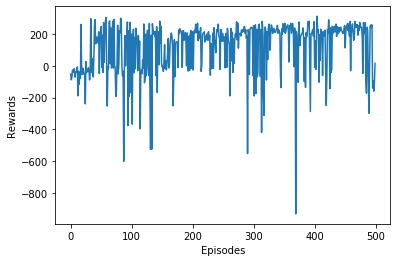

In [120]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(episodes), total_rewards)

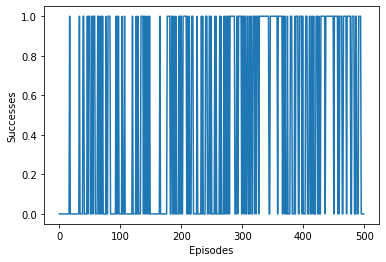

In [122]:
suc = []
for i in total_rewards:
    if i >= 200:
        suc.append(1)
    else:
        suc.append(0)

plt.xlabel("Episodes")
plt.ylabel("Successes")
plt.plot(range(episodes), suc)

In [127]:
test=DQNAgent(env)
trials = 1000
epochs, successes, total_rewards_test = test.play("cervello_positronico", trials, render=False)

00, reward = 94.01050932645113
Completed/Episodes 649/1000, reward = -110.42140982047876
Completed/Episodes 650/1000, reward = 258.8074628646238
Completed/Episodes 651/1000, reward = 193.72663470982073
Completed/Episodes 652/1000, reward = -110.98022298844685
Completed/Episodes 653/1000, reward = -69.52855188608109
Completed/Episodes 654/1000, reward = 262.2515334757892
Completed/Episodes 655/1000, reward = 237.92801289329796
Completed/Episodes 656/1000, reward = 197.15306003808774
Completed/Episodes 657/1000, reward = 278.9959072965561
Completed/Episodes 658/1000, reward = 212.59565765042498
Completed/Episodes 659/1000, reward = 209.569777641566
Completed/Episodes 660/1000, reward = 236.66814805011646
Completed/Episodes 661/1000, reward = 31.81024203434862
Completed/Episodes 662/1000, reward = 239.23930127509695
Completed/Episodes 663/1000, reward = 212.18746591960362
Completed/Episodes 664/1000, reward = 257.6134954215723
Completed/Episodes 665/1000, reward = 73.90328853904205
Comple

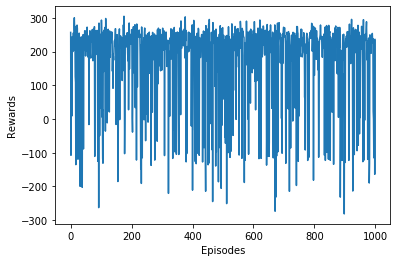

In [128]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(trials), total_rewards_test)